# STORM database and intensity exceedance

This notebook involves importing STORM synthetic database in a CLIMADA environment.

In [1]:
from climada.hazard import TCTracks, TropCyclone, Centroids
from datetime import datetime
import pandas as pd
from climada.entity import ImpfTropCyclone, ImpactFunc, Exposures, ImpactFuncSet
import numpy as np
from dateutil.relativedelta import relativedelta
from climada.util.plot import plot_from_gdf
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from climada.util.constants import CMAP_IMPACT
from climada.engine import ImpactCalc
import cartopy.feature as cfeature

We want to see the situations for all of the energy sectors. To pilot the pipeline, we use 'coal' as the focal example first.

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr10"
})
plt.rcParams['font.size'] = 12
mpl.rcParams['axes.unicode_minus'] = True

In [3]:
tracks_sync_1000yr = TCTracks.from_simulations_storm('../Data/STORM_DATA_HadGEM3-GC31-HM_NI_1000_YEARS_0_IBTRACSDELTA.txt')
years = [int(tr.attrs['id_no'] / 1000) for tr in tracks_sync_1000yr.data]
return_periods = [5,10,25,50,100,200,500,1000]

In [4]:
extent_india = [68.7, 97.3, 7, 38]

In [5]:
def ordinal_to_date(ordinal_array):
    return [datetime.fromordinal(int(d)) for d in ordinal_array]

In [6]:
intensity = pd.read_excel('../intensity_array.xlsx')
damage_curve_intensity = np.array(intensity.iloc[:,0])
intensity_ratio_pair = pd.read_excel('../intensity_filled.xlsx')
intensity_ratio_pair = intensity_ratio_pair[['intensity','damage']]

In [7]:
impFunc_emanuel_usa = ImpfTropCyclone.from_emanuel_usa(impf_id=1, intensity=damage_curve_intensity, v_thresh=25.7, v_half=70.8, scale=1.0)

In [8]:
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()

In [9]:
def intensity_to_ratio(intensity):
    if intensity <= intensity_ratio_pair['intensity'][0]:
        ratio = float(0)
        return ratio
    else:
        i = 1
        while i<= len(intensity_ratio_pair)-1:
            if intensity <= intensity_ratio_pair['intensity'][i] and intensity >= intensity_ratio_pair['intensity'][i-1]:
                if intensity_ratio_pair['damage'][i] == 0:
                    ratio = float(0)
                    return ratio
                else:
                    ratio = intensity_ratio_pair['damage'][i-1] + ((intensity_ratio_pair['damage'][i]-intensity_ratio_pair['damage'][i-1])/(intensity_ratio_pair['intensity'][i]-intensity_ratio_pair['intensity'][i-1]))*(intensity-intensity_ratio_pair['intensity'][i-1])
                    return ratio
            else:
                i += 1
            ratio = float(0)    
    return ratio

We first import the asset locations.

In [15]:
def rp_graphs(file):
    exposures = pd.read_excel(file)
    exp = Exposures(exposures, ref_year=2024)
    lat = exposures["latitude"].values
    lon = exposures["longitude"].values
    centrs = Centroids.from_lat_lon(lat, lon)
    storm = TropCyclone.from_tracks(tracks_sync_1000yr, centroids=centrs, store_windfields=True)
    original_tcdate = storm.date
    tc_date = storm.date
    ordinal_dates = storm.date
    normal_dates = ordinal_to_date(ordinal_dates)
    adjusted_dates = [dt + relativedelta(years=yr) for dt, yr in zip(normal_dates, years)]
    final_dates = [dt.toordinal() for dt in adjusted_dates]
    storm.date = np.array(final_dates)
    storm.frequency_from_tracks(tracks_sync_1000yr.data)
    storm.frequency=np.array([0.001]*1797)
    local_exceedance_impacts, title, column_label = storm.local_exceedance_intensity(return_periods=return_periods, method='extrapolate_constant')
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()

    for i, ax in enumerate(axes):
        local_exceedance_impacts, title, column_label = storm.local_exceedance_intensity(return_periods=[return_periods[i]], method='extrapolate_constant')
        plot_from_gdf(local_exceedance_impacts, title, column_label, axis=ax, figsize=None, smooth=True, vmin=0, vmax=80)
        ax.set_extent(extent_india, crs=ccrs.PlateCarree())
        ax.scatter(lon,
        lat,
        marker="o",
        s=5,
        facecolor="none",
        edgecolor="red",
        transform=ccrs.PlateCarree())

    plt.tight_layout()
    plt.show()

In [16]:
def rp_graphs_ratio(file):
    exposures = pd.read_excel(file)
    exp = Exposures(exposures, ref_year=2024)
    lat = exposures["latitude"].values
    lon = exposures["longitude"].values
    centrs = Centroids.from_lat_lon(lat, lon)
    storm = TropCyclone.from_tracks(tracks_sync_1000yr, centroids=centrs, store_windfields=True)
    original_tcdate = storm.date
    tc_date = storm.date
    ordinal_dates = storm.date
    normal_dates = ordinal_to_date(ordinal_dates)
    adjusted_dates = [dt + relativedelta(years=yr) for dt, yr in zip(normal_dates, years)]
    final_dates = [dt.toordinal() for dt in adjusted_dates]
    storm.date = np.array(final_dates)
    storm.frequency_from_tracks(tracks_sync_1000yr.data)
    storm.frequency=np.array([0.001]*1797)

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()

    for i, ax in enumerate(axes):
        return_period = return_periods[i]
        local_exceedance_impact_ratios, title, column_label = storm.local_exceedance_intensity(return_periods=[return_period], method='extrapolate_constant')
        
        ratio_values = []
        for intensity in local_exceedance_impact_ratios[f'{return_period}'].values:
            ratio_values.append(intensity_to_ratio(intensity))

        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_extent(extent_india, crs=ccrs.PlateCarree())
        sc = ax.scatter(
            lon, lat,
            c=ratio_values,
            cmap="Reds",
            s=30,
            edgecolor="black",
            linewidth=0.5,
            transform=ccrs.PlateCarree(),
            vmin=0, vmax=1
        )
        ax.set_title(f"Return Period: {return_period} years")

        # A colorbar is set here, similar with the original one of plot_from_gdf
        cbar = fig.colorbar(sc, ax=ax, orientation="vertical", fraction=0.05, pad=0.05)
        cbar.set_label("Damage Ratio")

    plt.tight_layout()
    plt.show()

In [17]:
def rp_graphs_damage(file):
    exposures = pd.read_excel(file)
    exp = Exposures(exposures, ref_year=2024) # this is exposure
    lat = exposures["latitude"].values
    lon = exposures["longitude"].values
    centrs = Centroids.from_lat_lon(lat, lon)
    storm = TropCyclone.from_tracks(tracks_sync_1000yr, centroids=centrs, store_windfields=True) # this is Hazard
    original_tcdate = storm.date
    tc_date = storm.date
    ordinal_dates = storm.date
    normal_dates = ordinal_to_date(ordinal_dates)
    adjusted_dates = [dt + relativedelta(years=yr) for dt, yr in zip(normal_dates, years)]
    final_dates = [dt.toordinal() for dt in adjusted_dates]
    storm.date = np.array(final_dates)
    storm.frequency_from_tracks(tracks_sync_1000yr.data)
    storm.frequency=np.array([0.001]*1797)
    local_exceedance_intensities, title, column_label = storm.local_exceedance_intensity(return_periods=return_periods, method='extrapolate_constant')
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    impact = ImpactCalc(exp, impf_set, storm).impact(save_mat=True)

    axes = axes.flatten()

    for i, ax in enumerate(axes):

        loacl_exceedance_impacts, title, column_label = impact.local_exceedance_impact(
            return_periods=[return_periods[i]], method='extrapolate_constant')

        plot_from_gdf(
            loacl_exceedance_impacts, title, column_label, axis=ax, figsize=None, smooth=True, cmap=CMAP_IMPACT, vmin=0, vmax=1.4*(10**9))

        ax.set_extent(extent_india, crs=ccrs.PlateCarree())

    plt.tight_layout()
    plt.show()

### Local_exceedance_intensities

Coal

C:\Users\Admin\AppData\Local\Temp\ipykernel_21588\1900734995.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered 

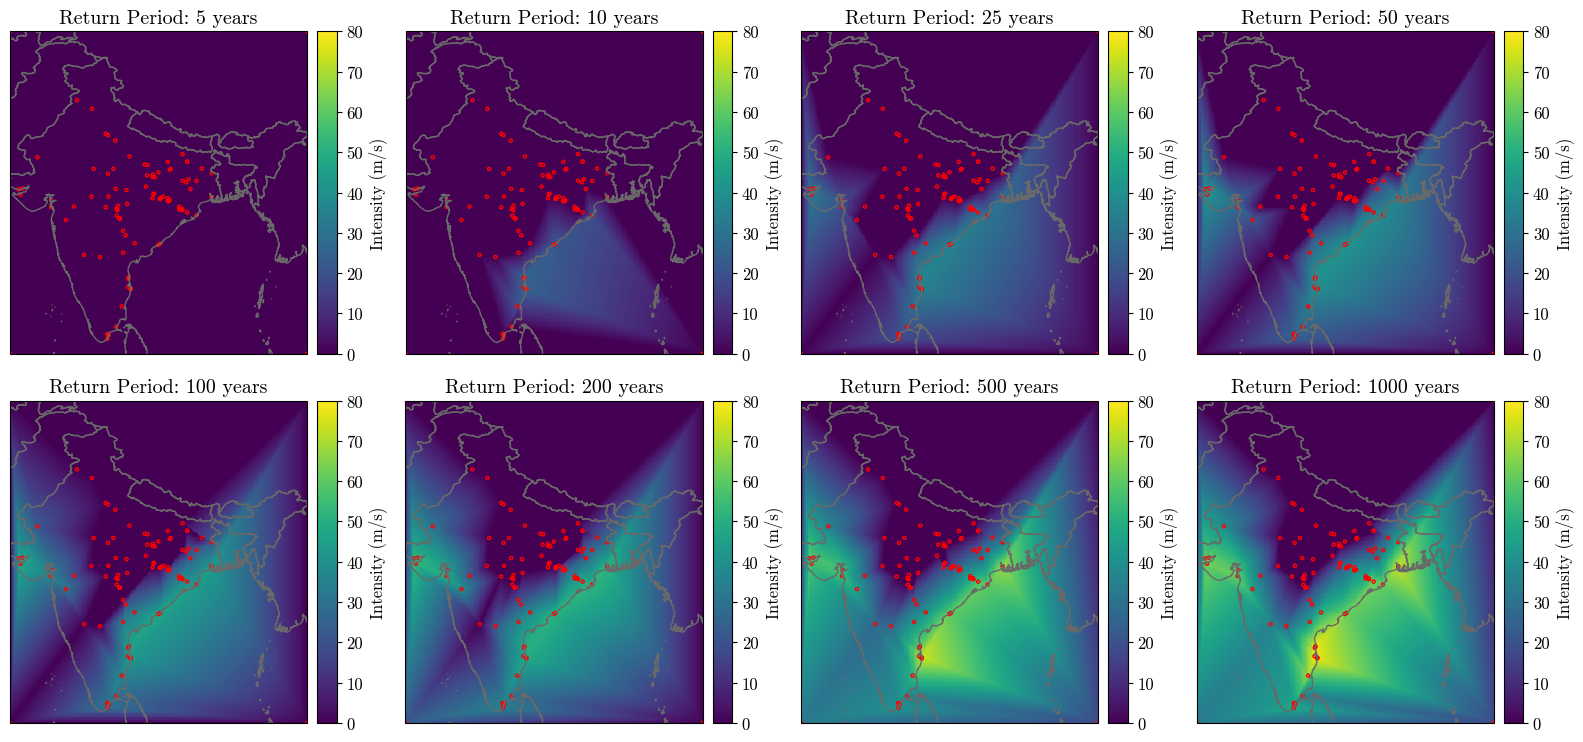

In [22]:
rp_graphs('exposures/exposures_coal.xlsx')

Bio

C:\Users\Admin\AppData\Local\Temp\ipykernel_21588\1900734995.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered 

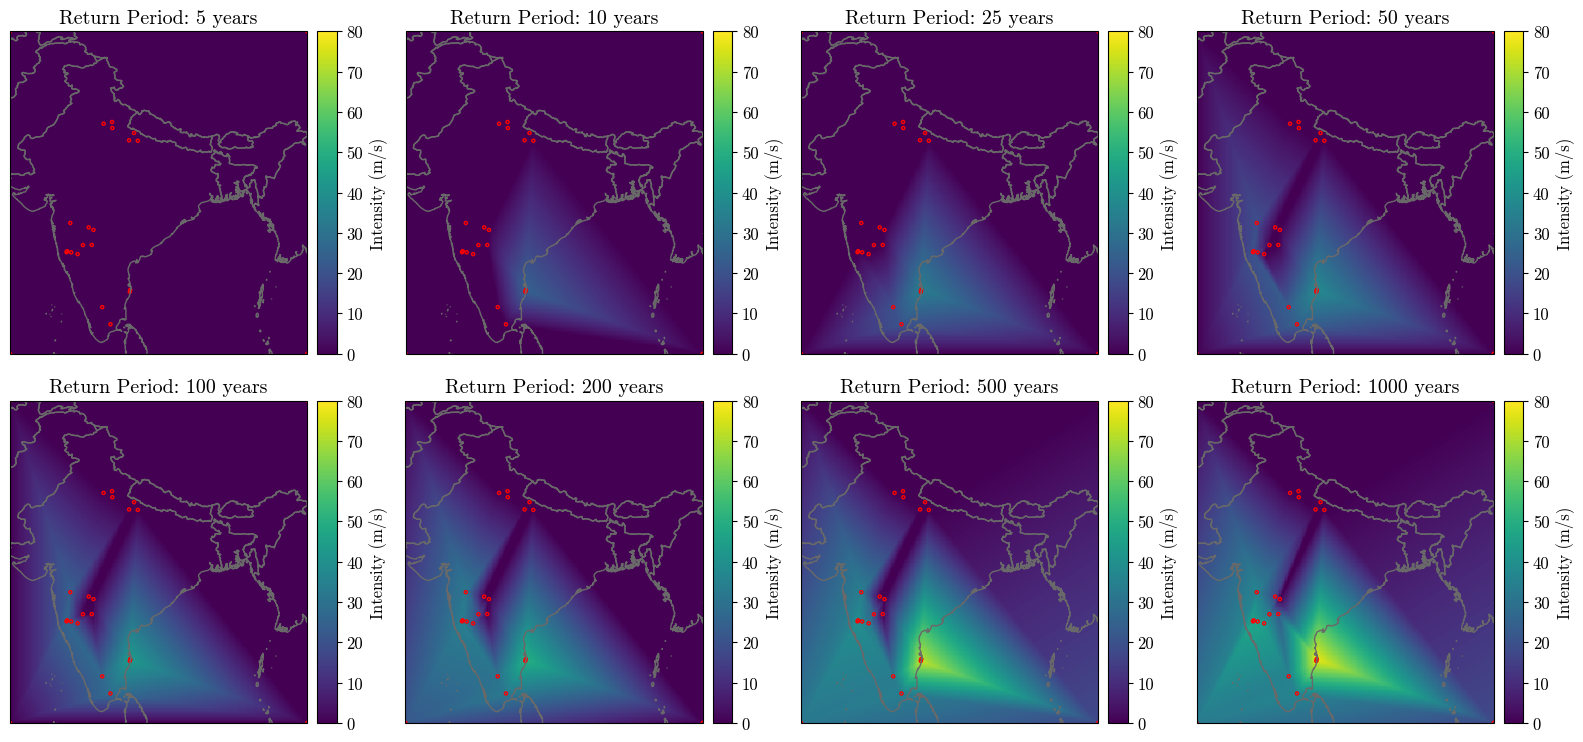

In [23]:
rp_graphs('exposures/exposures_bioenergy.xlsx')

Nuclear

C:\Users\Admin\AppData\Local\Temp\ipykernel_21588\1900734995.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered 

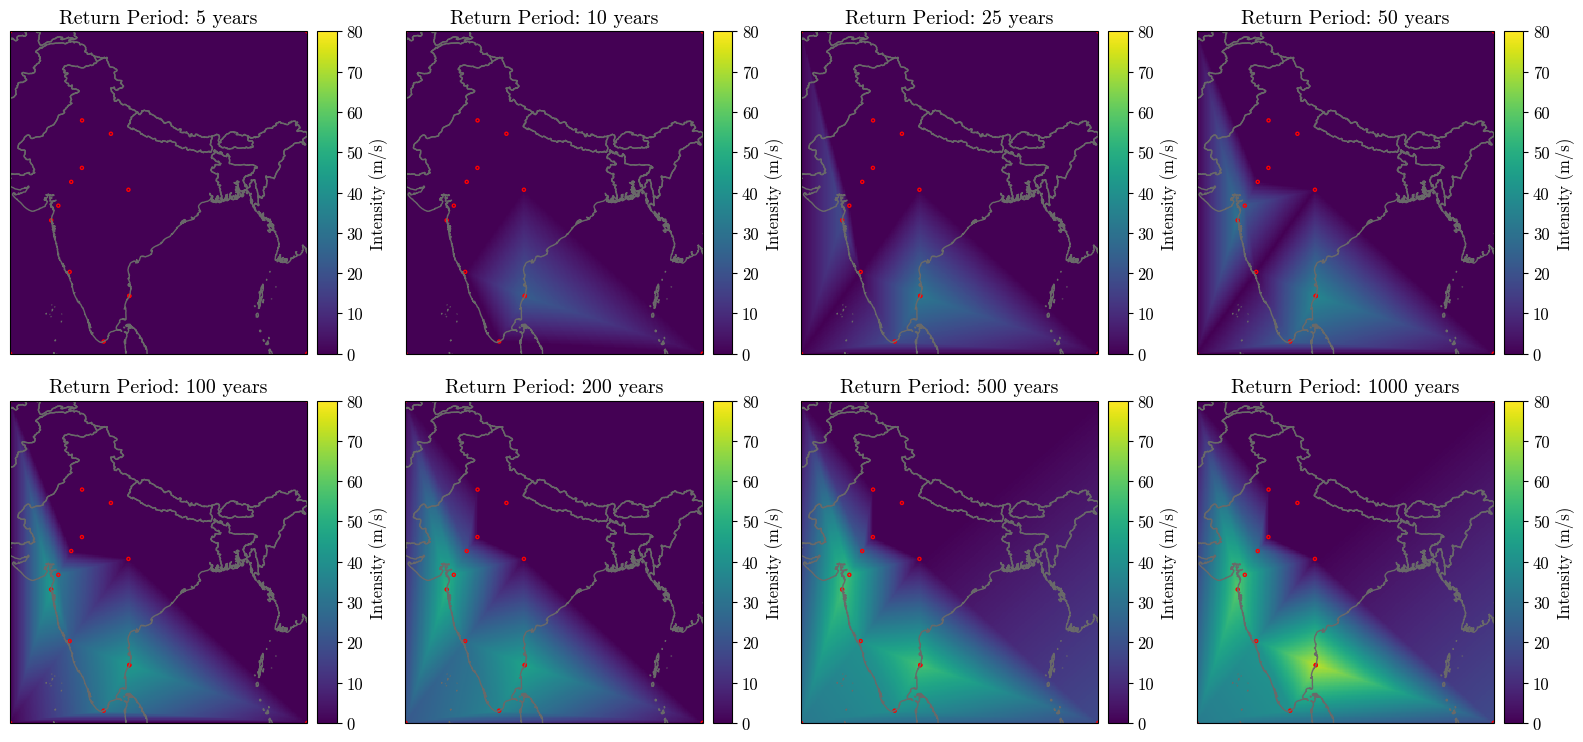

In [24]:
rp_graphs('exposures/exposures_nuclear.xlsx')

Oil & gas

C:\Users\Admin\AppData\Local\Temp\ipykernel_21588\1900734995.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered 

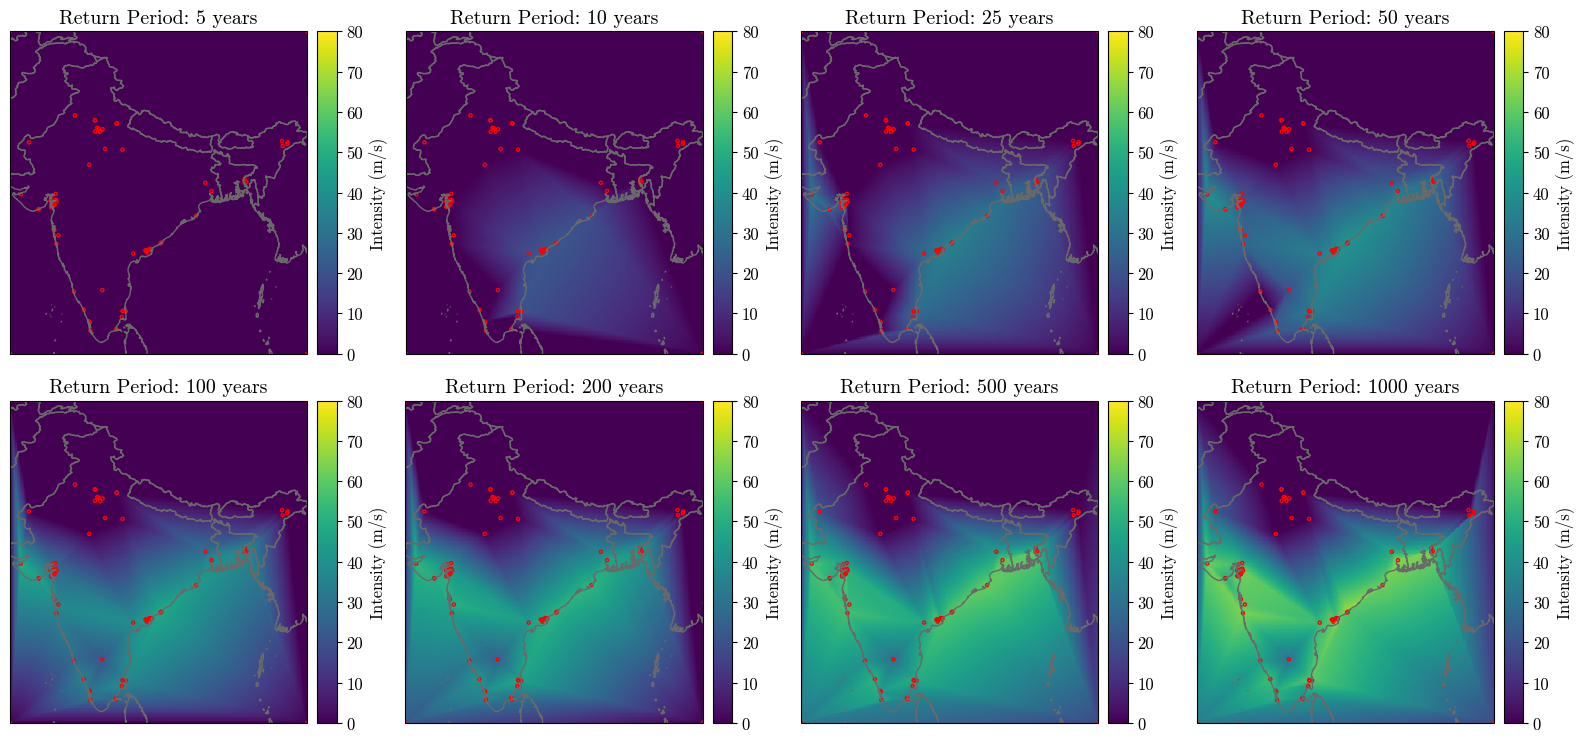

In [25]:
rp_graphs('exposures/exposures_oilgas.xlsx')

In [ ]:
def exceedance_curve_generator(exposure_file):
    exposures = pd.read_excel(exposure_file)
    asset_lat = exposures["latitude"].values
    asset_lon = exposures["longitude"].values
    centorids = Centroids.from_lat_lon(asset_lat, asset_lon)
    storm = TropCyclone.from_tracks(tracks_sync_1000yr, centroids=centorids, store_windfields=True)
    normal_dates = ordinal_to_date(storm.date)
    adjusted_dates = [dt + relativedelta(years=yr) for dt, yr in zip(normal_dates, years)]
    final_dates = [dt.toordinal() for dt in adjusted_dates]
    storm.date = np.array(final_dates)
    storm.frequency_from_tracks(tracks_sync_1000yr.data)
    storm.frequency=np.array([0.001]*1797)
    local_exceedance_impacts, title, column_label = storm.local_exceedance_intensity(return_periods=[5, 10, 25, 50, 100, 200, 500, 1000], method='extrapolate_constant')
    df = pd.DataFrame(local_exceedance_impacts.drop(columns=['geometry']))
    df.to_excel('exceedence'+exposure_file[18:-5]+'_new.xlsx', index=False)

Coal

In [24]:
exceedance_curve_generator('exposures/exposure_coal.xlsx')

C:\Users\Admin\AppData\Local\Temp\ipykernel_27440\933073879.py:5: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centorids = Centroids.from_lat_lon(asset_lat, asset_lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)


Bio

In [25]:
exceedance_curve_generator('exposures/exposure_bioenergy.xlsx')

C:\Users\Admin\AppData\Local\Temp\ipykernel_27440\933073879.py:5: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centorids = Centroids.from_lat_lon(asset_lat, asset_lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)


OilGas

In [26]:
exceedance_curve_generator('exposures/exposure_oilgas.xlsx')

C:\Users\Admin\AppData\Local\Temp\ipykernel_27440\933073879.py:5: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centorids = Centroids.from_lat_lon(asset_lat, asset_lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)


Nuclear

In [27]:
exceedance_curve_generator('exposures/exposure_nuclear.xlsx')

C:\Users\Admin\AppData\Local\Temp\ipykernel_27440\933073879.py:5: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centorids = Centroids.from_lat_lon(asset_lat, asset_lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)


Local visulisations on certain areas.

C:\Users\Admin\AppData\Local\Temp\ipykernel_22236\3754605508.py:5: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)


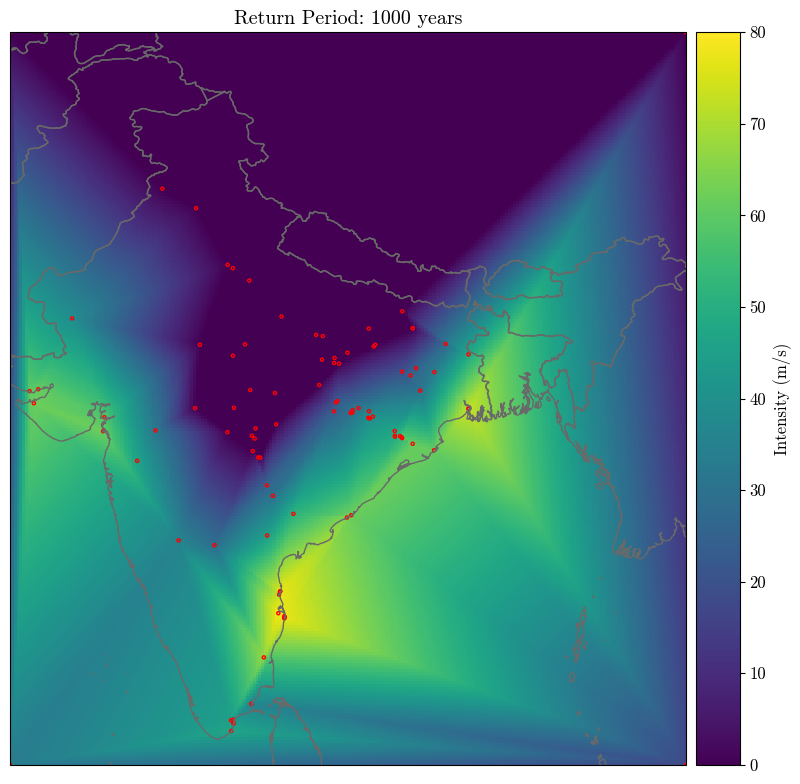

In [16]:
exposures_coal = pd.read_excel('exposures/exposures_coal.xlsx')
exp = Exposures(exposures_coal, ref_year=2024)
lat = exposures_coal["latitude"].values
lon = exposures_coal["longitude"].values
centrs = Centroids.from_lat_lon(lat, lon)
storm = TropCyclone.from_tracks(tracks_sync_1000yr, 
    centroids=centrs, store_windfields=True)
original_tcdate = storm.date
tc_date = storm.date
ordinal_dates = storm.date
normal_dates = ordinal_to_date(ordinal_dates)
adjusted_dates = [dt + relativedelta(years=yr) for dt, yr in zip(normal_dates, years)]
final_dates = [dt.toordinal() for dt in adjusted_dates]
storm.date = np.array(final_dates)
storm.frequency_from_tracks(tracks_sync_1000yr.data)
storm.frequency=np.array([0.001]*1797)
local_exceedance_impacts, title, column_label = storm.local_exceedance_intensity(
    return_periods=[1000], 
    method='extrapolate_constant')

fig, ax = plt.subplots(
    figsize=(16, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

plot_from_gdf(local_exceedance_impacts, title, column_label, 
    axis=ax, figsize=None, smooth=True, vmin=0, vmax=80)
ax.set_extent(extent_india, crs=ccrs.PlateCarree())
ax.scatter(lon,
lat,
marker="o",
s=5,
facecolor="none",
edgecolor="red",
transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

### Local_exceedance_ratios

Coal

C:\Users\Admin\AppData\Local\Temp\ipykernel_22236\1759374614.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered 

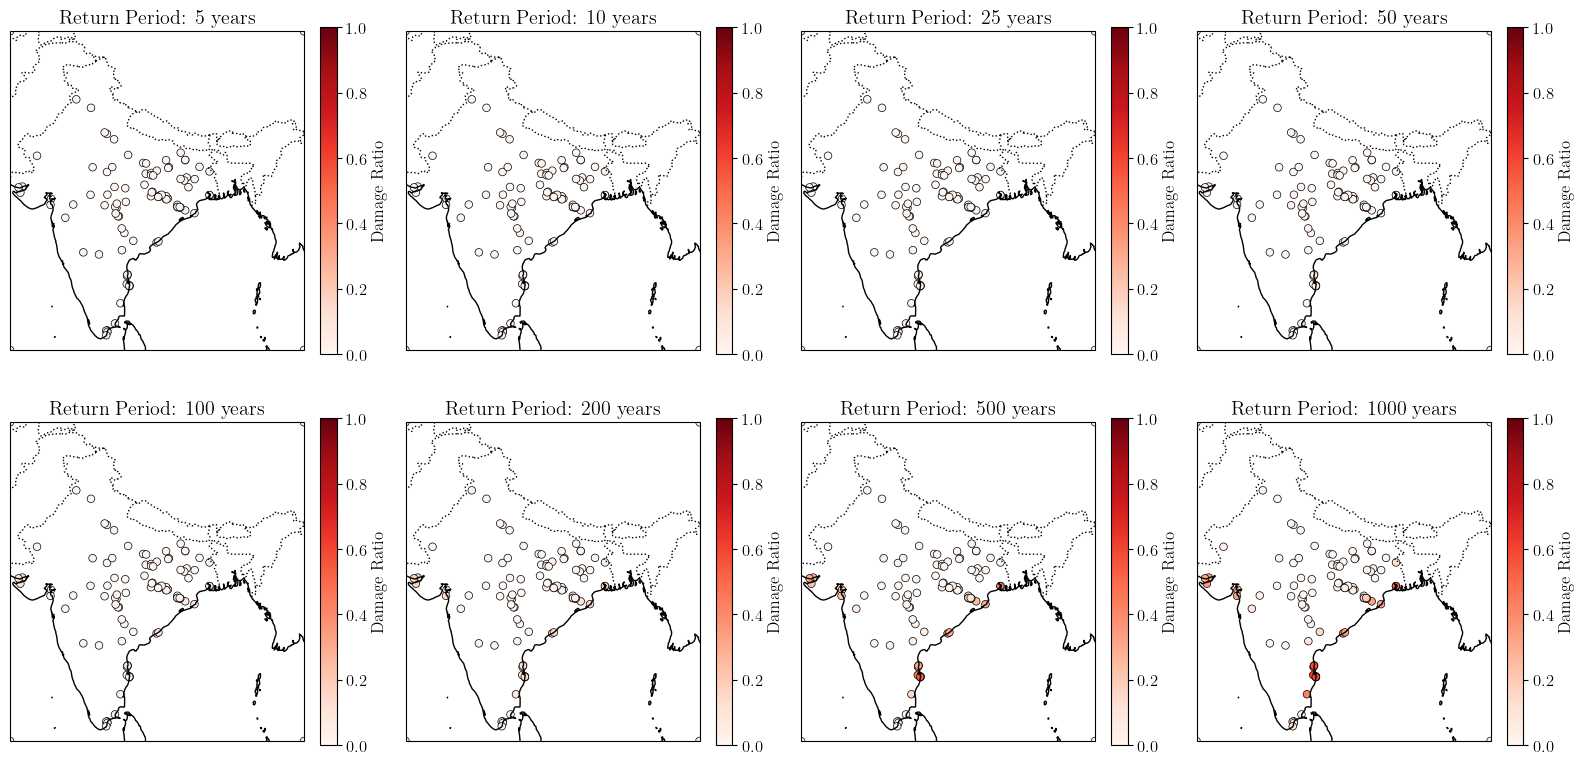

In [299]:
rp_graphs_ratio('exposures/exposures_coal.xlsx')

Nuclear

C:\Users\Admin\AppData\Local\Temp\ipykernel_22236\4093519869.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered 

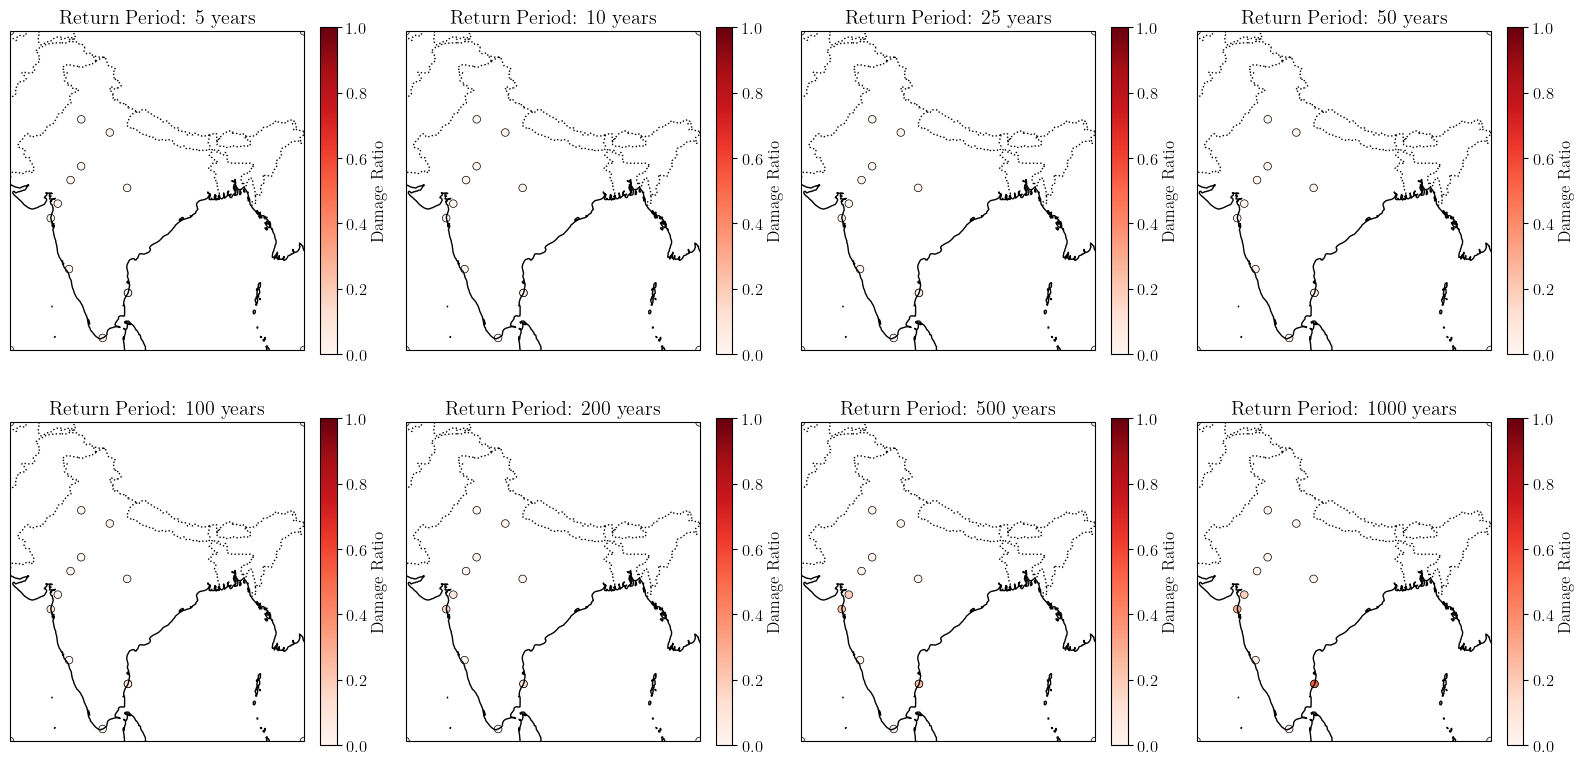

In [305]:
rp_graphs_ratio('exposures/exposures_nuclear.xlsx')

Bio

C:\Users\Admin\AppData\Local\Temp\ipykernel_22236\4093519869.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered 

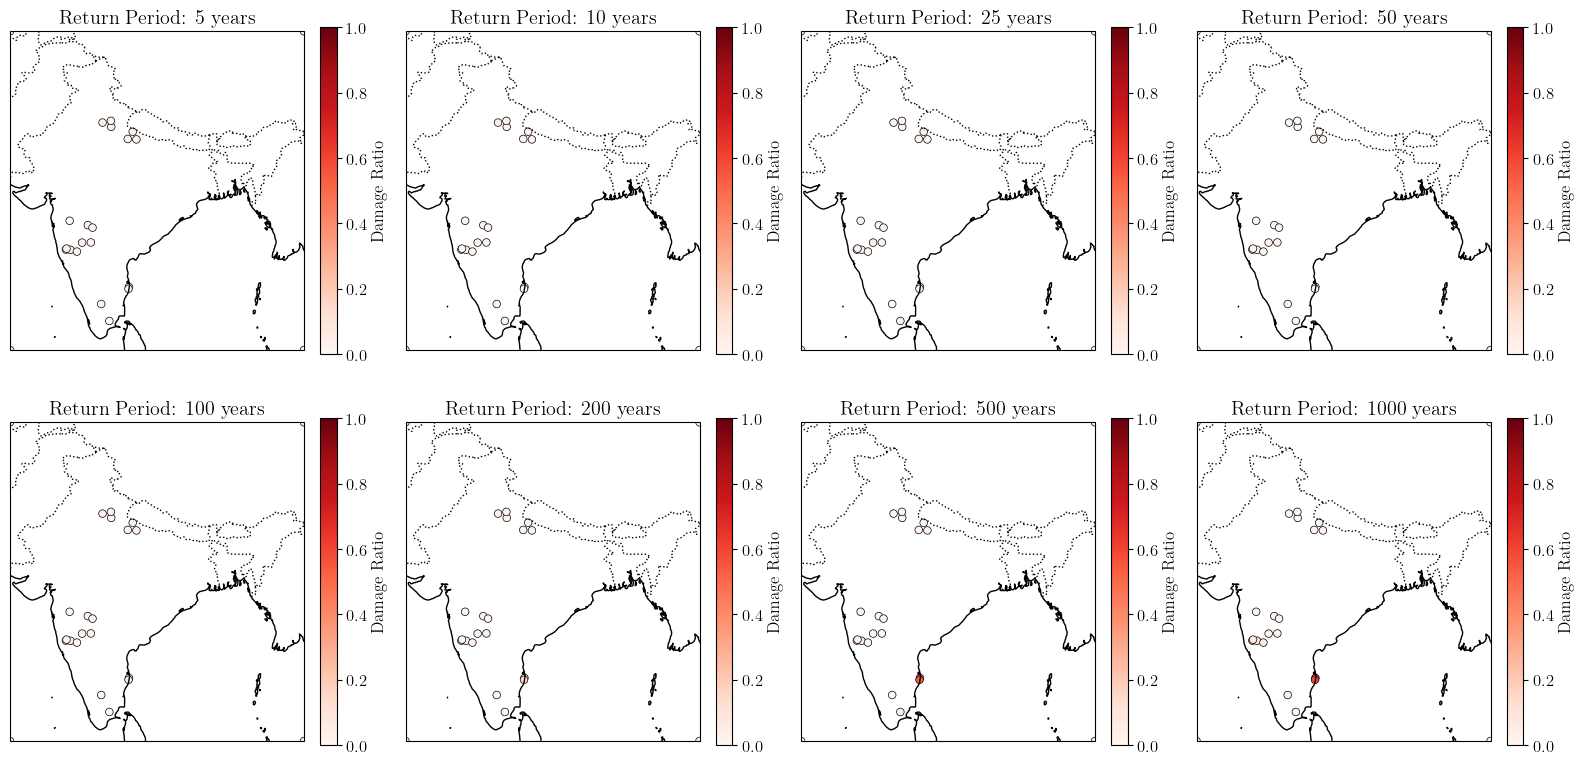

In [306]:
rp_graphs_ratio('exposures/exposures_bioenergy.xlsx')

Oil&Gas

C:\Users\Admin\AppData\Local\Temp\ipykernel_22236\4093519869.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered 

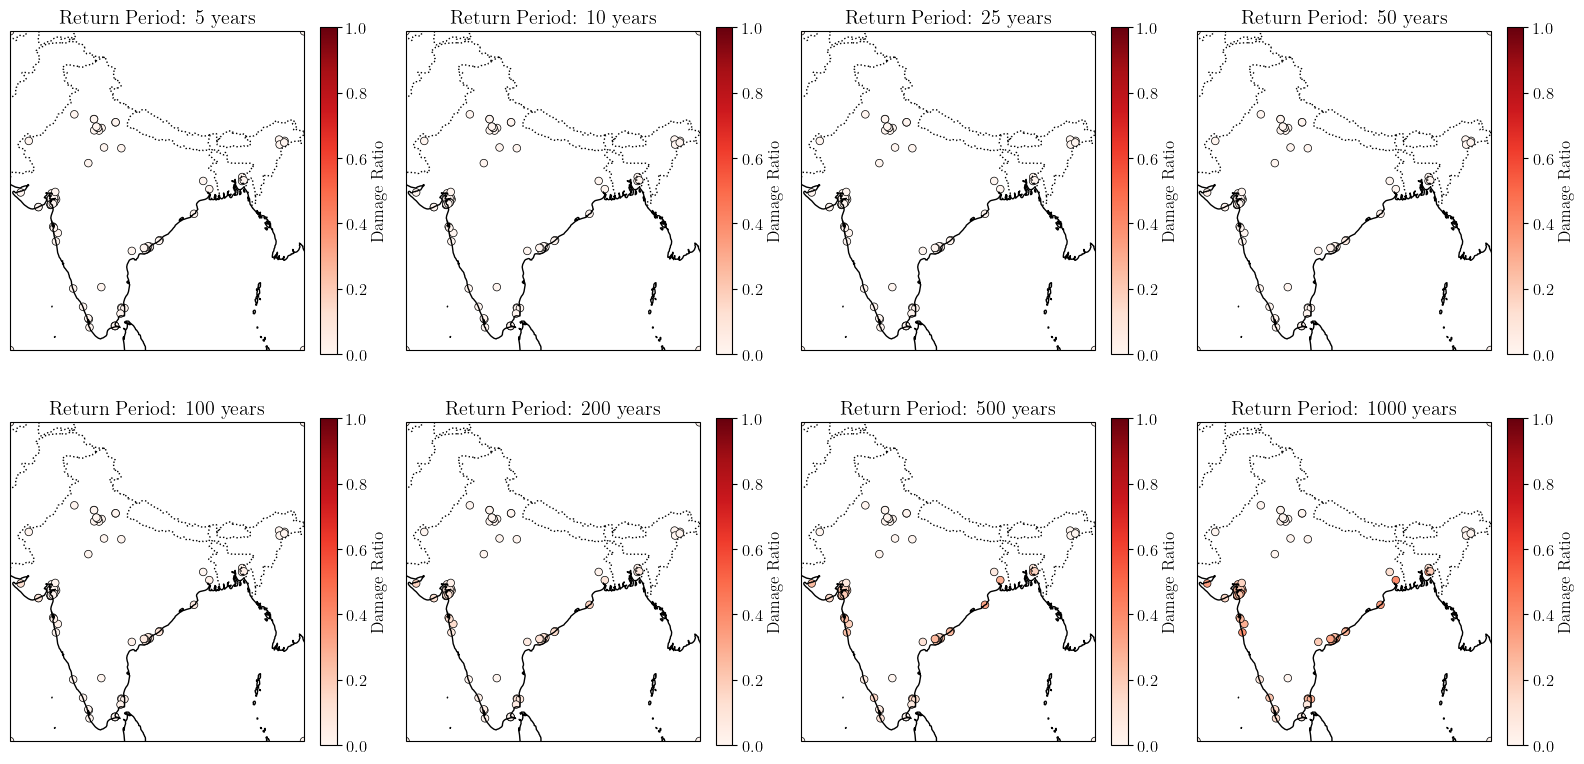

In [350]:
rp_graphs_ratio('exposures/exposures_oilgas.xlsx')

### Local_exceedance_impacts

Coal

C:\Users\Admin\AppData\Local\Temp\ipykernel_22236\87587919.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in

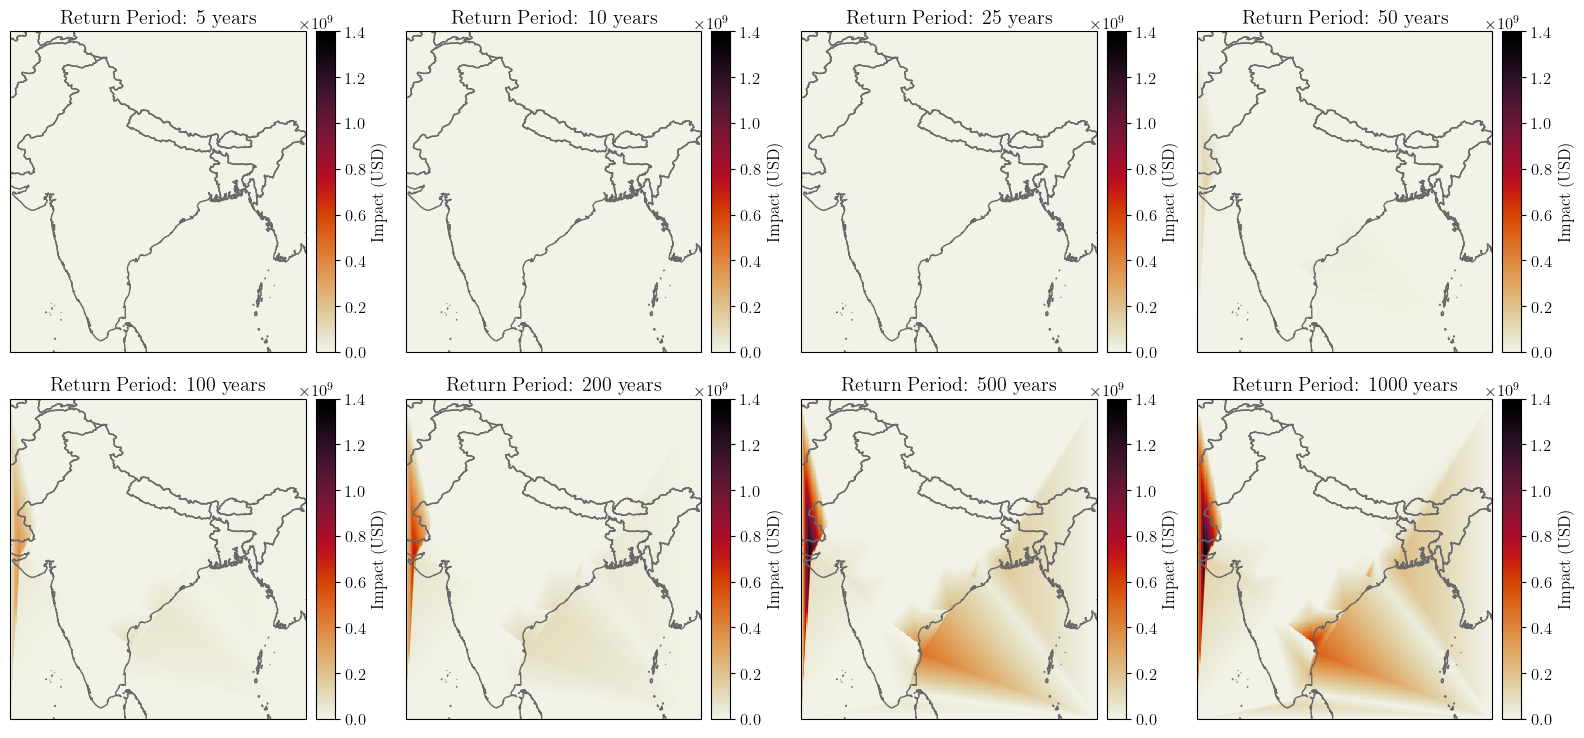

In [173]:
rp_graphs_damage('exposures/exposures_coal.xlsx')

Nuclear

C:\Users\Admin\AppData\Local\Temp\ipykernel_22236\87587919.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)


2025-08-08 15:32:09,063 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 5 coordinates.


c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train

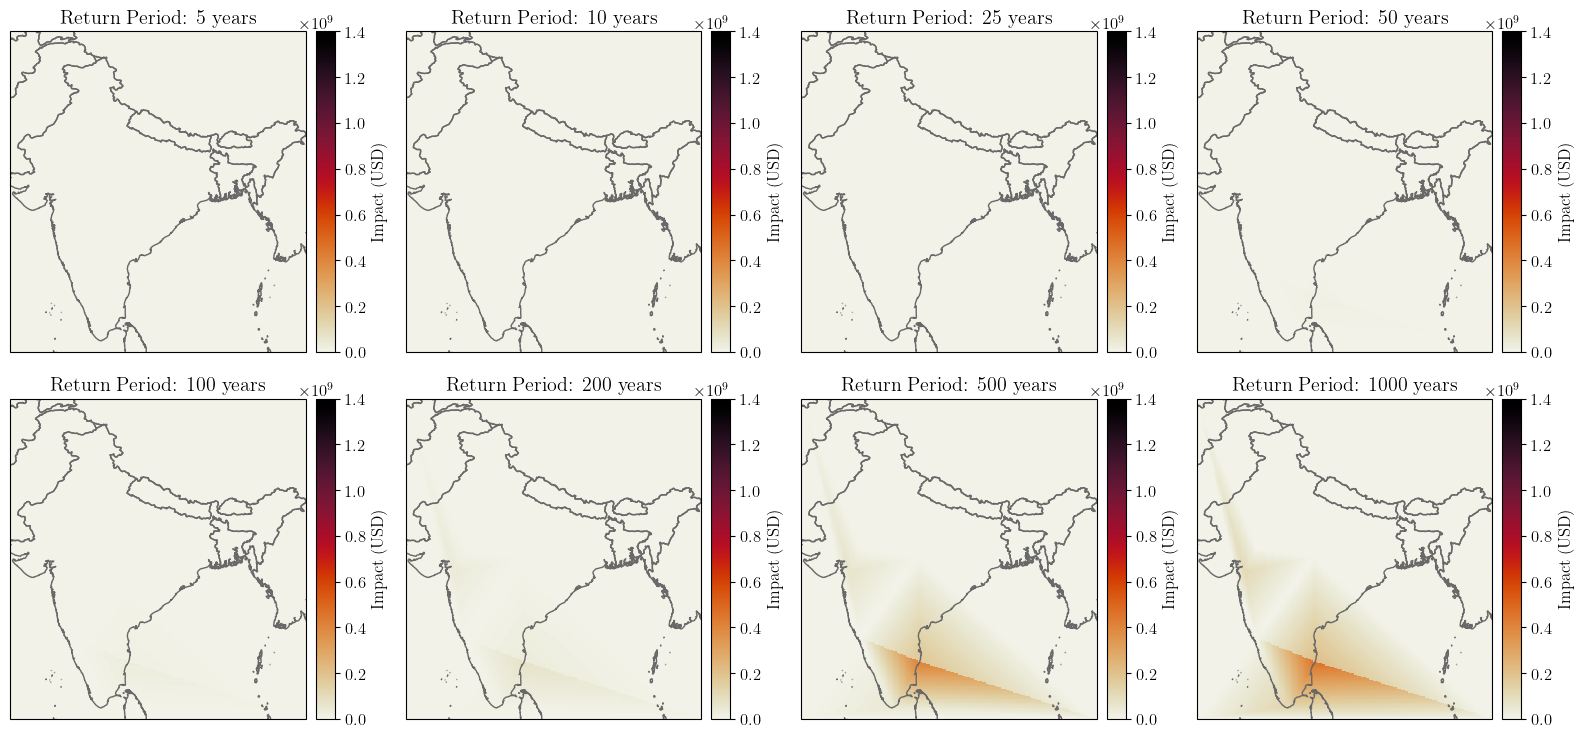

In [175]:
rp_graphs_damage('exposures/exposures_nuclear.xlsx')

Bio

In [43]:
def rp_graphs_damage2(file):
    exposures = pd.read_excel(file)
    exp = Exposures(exposures, ref_year=2024) # this is exposure
    lat = exposures["latitude"].values
    lon = exposures["longitude"].values
    centrs = Centroids.from_lat_lon(lat, lon)
    storm = TropCyclone.from_tracks(tracks_sync_1000yr, centroids=centrs, store_windfields=True) # this is Hazard
    original_tcdate = storm.date
    tc_date = storm.date
    ordinal_dates = storm.date
    normal_dates = ordinal_to_date(ordinal_dates)
    adjusted_dates = [dt + relativedelta(years=yr) for dt, yr in zip(normal_dates, years)]
    final_dates = [dt.toordinal() for dt in adjusted_dates]
    storm.date = np.array(final_dates)
    storm.frequency_from_tracks(tracks_sync_1000yr.data)
    storm.frequency=np.array([0.001]*1797)
    local_exceedance_intensities, title, column_label = storm.local_exceedance_intensity(return_periods=return_periods, method='extrapolate_constant')
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    impact = ImpactCalc(exp, impf_set, storm).impact(save_mat=True)

    axes = axes.flatten()

    for i, ax in enumerate(axes):

        loacl_exceedance_impacts, title, column_label = impact.local_exceedance_impact(
            return_periods=[return_periods[i]], method='extrapolate_constant')

        plot_from_gdf(
            loacl_exceedance_impacts, title, column_label, axis=ax, figsize=None, smooth=True, cmap=CMAP_IMPACT, vmin=0, vmax=1*(10**8))

        ax.set_extent(extent_india, crs=ccrs.PlateCarree())

    plt.tight_layout()
    plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_55780\3703571000.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered 

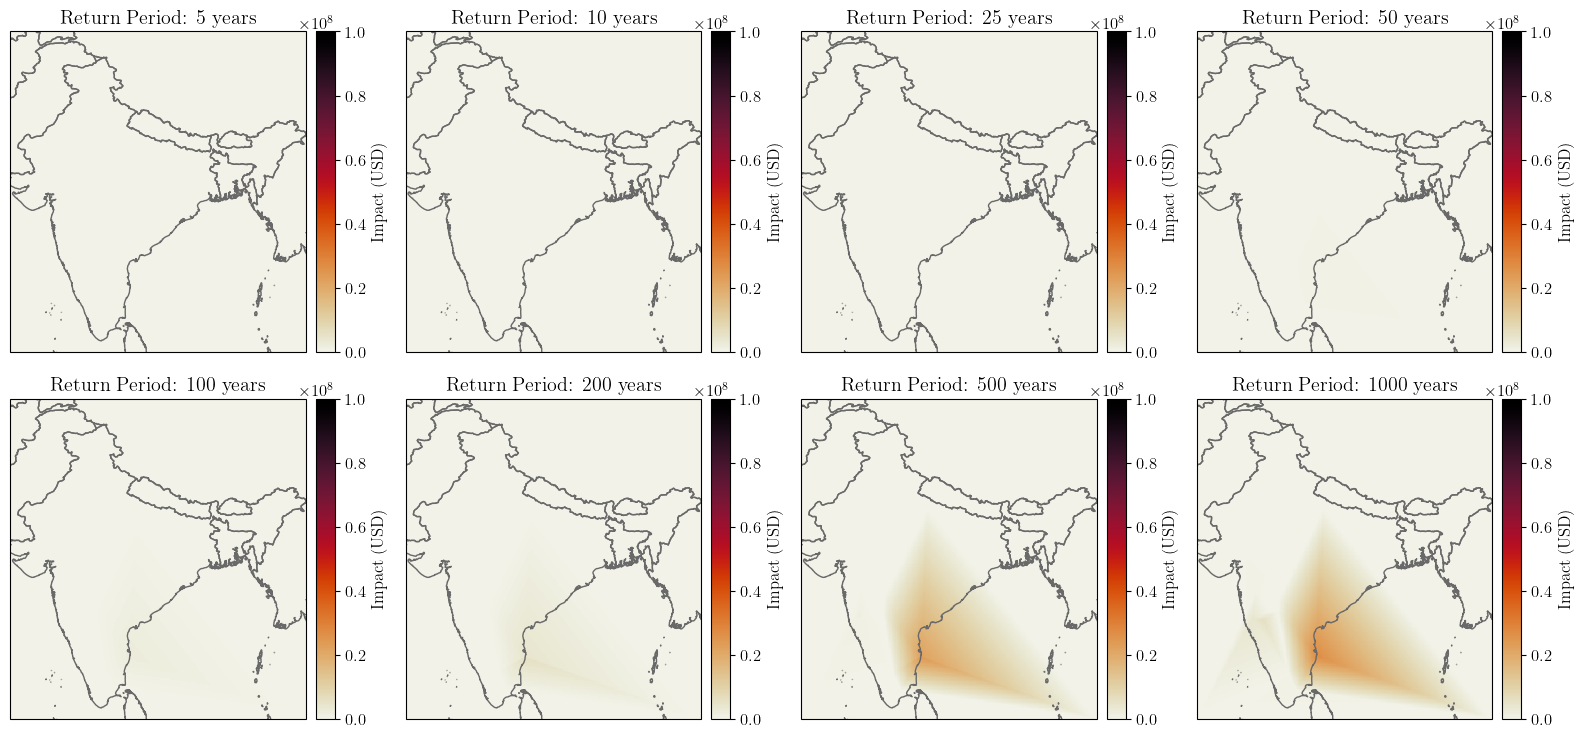

In [44]:
rp_graphs_damage2('exposures/exposures_bioenergy.xlsx')

Oil&Gas

C:\Users\Admin\AppData\Local\Temp\ipykernel_22236\87587919.py:6: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)


2025-08-08 15:36:29,144 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 39 coordinates.


c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train[0], np.log10(y_asymptotic) if logy else y_asymptotic)
c:\users\admin\desktop\climada\climada_python\climada\util\interpolation.py:214: RuntimeWarning: divide by zero encountered in log10
  fill_value = (y_train

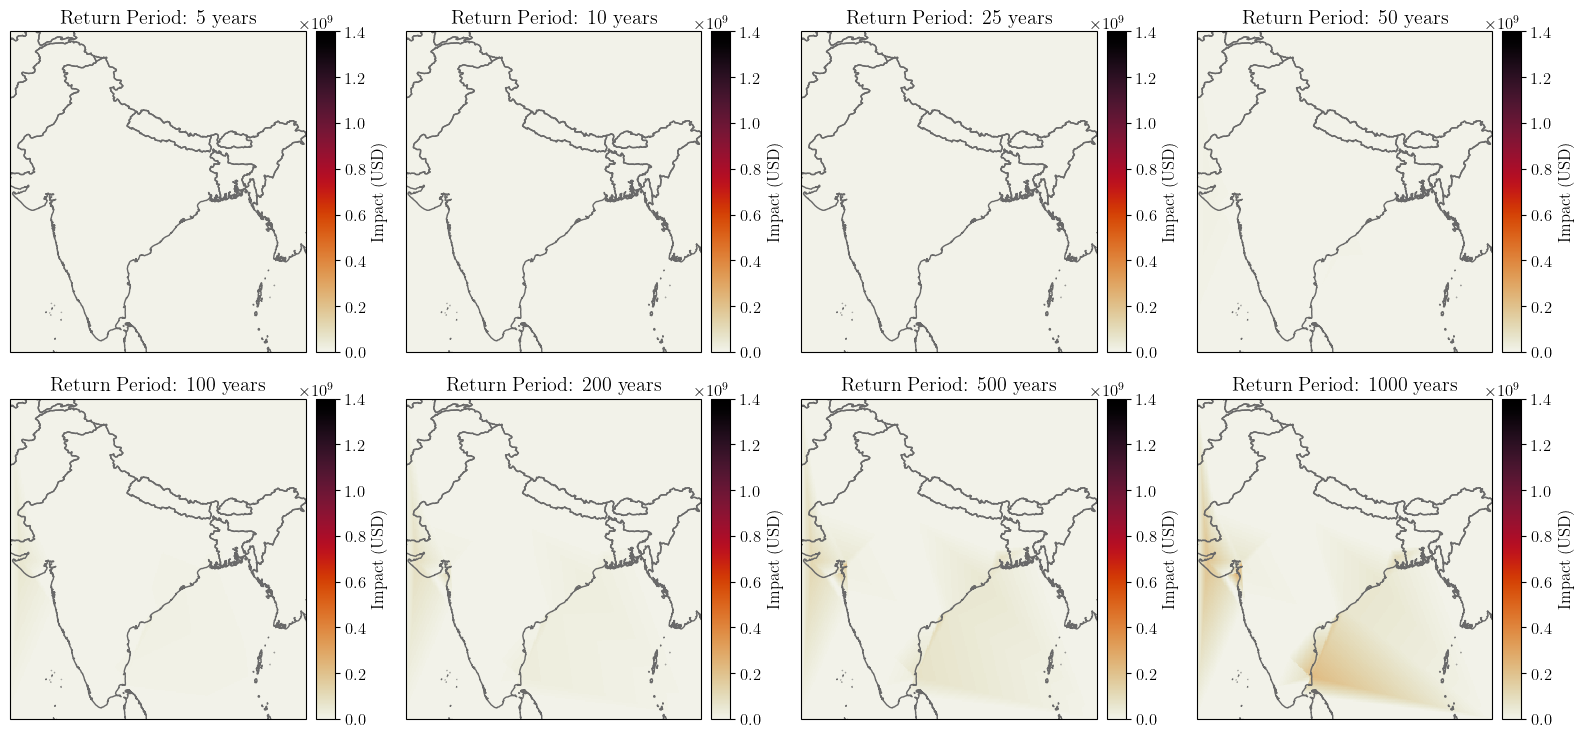

In [178]:
rp_graphs_damage('exposures/exposures_oilgas.xlsx')